# Types of Stationary Behavior in a Time Series

Stationary data means that its statistical properties do not vary with time. There are 5 forms:
- Strict / strong stationary: no changes even if shifted
- first-order stationary: constant mean
- weak (second-order) stationary: mean, variance and covariance are constant throughout the series
- trend stationary: varies around the trends (statistical mean property varies), can be linear or quadric
- difference stationary


### Making data stationary

When data is nonstationary, it means it has trend and seasonality patterns that NEED TO BE removed. By making it stationary, data will have a constant mean and variance. To check whether data is stationary, use three methods:
- plots
- summary statistics
- statistics tests


### Plots

A plot that is not increasing or decreasing and shows constant growth over time is known as a stationary time series.

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

sns.set()
plt.rcParams['figure.figsize'] = (15, 5)

### Statistics unit root tests

Unit root tests' concept is that the statistical property of a given time series is not constant with time. Here, we would use statistical tests to check whether a time series is stationary.

- Dickey-Fuller test: This is based on linear regression. Serial correlation is a big issue of this method.

- Augmented Dickey-Fuller test : This solves the serial correlation problem of a DF test and handles big and complex models. This method is widely used.

- The Schmidt-Phillips test : This comprises the coefficients of the deterministic variables in the null and alternative hypotheses. Substitutes of this method are ro-test and tau-test.

- The Phillips-Perron (PP) test : This test is a betterment of the Dickey-Fuller test, and it embellishes the test for autocorrelation and heteroscedasticity in the errors.

- KPSS test: This is the reverse of the ADF test where the null hypothesis is the process of stationary trends and an alternative hypothesis for unit roots.


#### Interpreting the p-value

null hypothesis (H0) = not stationary
alternate hypothesis (H1) = stationary

If the p-value is below the threshold, then we reject the null hypothesis, which means that the time series is stationary. If the p-value exceeds the threshold and we fail to reject the null hypothesis, it means that the time series is nonstationary. An ADF test looks at the test statistic, the p-value, and the critical values found at 1%, 2.5%, 5%, and 10% confidence intervals.


##### Augmented Dickey-Fuller test

This test uses a negative number. More negative = higher the chance of rejecting the hypothesis

$H_0$ : Data has unique roots and time series is **non-stationary**.
$H_1$ : Data has no unique roots and time series **is stationary**.


##### KPSS: trend stationary

$H_0$ : **no** unit root and stationary time series
$H_1$ : **unit** root and non-stationary time series


---

### Make data stationary

##### Differencing (lag difference) = stabilize mean

Reasons for differencing:
- To convert non-stationary data into stationary time series
- To remove seasonal trends (4th for quarterly, 12th for monthly data)

##### First-order differencing (trend differencing)
- will remove a linear trend (differences=1)
- will remove a quadratic trend (differences=2)
- at a lag equal to the period will remove a seasonal trend 

## Autocorrelation and partial autocorrelation functions

Autocorrelation function (ACF) is a method to determine the linear relationship between t and t-1. After checking ACF, it helps to determine if differencing is required or not.

Autocorrelation (serial correlation) is the situation when the random error is more gradual to the last random error. Since data is independent, regression fails to capture trends. In this situation, the random error is positively correlated with time.

##### Steps to identify whether data is showing an AR or MA signature:
- plot or use an ADF test to check whether a series is stationary
- if time series **does not** have a stationary difference, check for stationary
- plot acf and pacf and use the table below to determine p and q for the model

| --- | --- | --- |
| Model | ACF pattern | PACF pattern |
| AR (p) | Exponential decay or damped sine wave pattern of both | significant spike through first lag |
| MA (q) | significant spike through first lag | exponentail decay |
| ARMA (1, 1) | Exponential decay from lag 1 | Exponential decay from lag 1 |
| ARMA (p, q) | Exponential decay | Exponential decay |

### ARIMA model (univariate; predict trend)

It has three components:
- autoregressive part (AR) -> lagged dependent variable, depends on some linear grouping of the previous value, which defined maximum lags (signified p). It also contains an arbitrary error term εt
- integration part (I)
- moving average part (MA) -> part of a time-series Yt, which is an observed value in terms of a random error and some linear grouping of previous arbitrary error terms, up to a described maximum lag (signified q

---

AR = effect of past value on model (p)
I  = nonseasonal differences needed for stationarity (d)
MA = lagged forecast errors in the prediction equation (q)

<img src="imgs/arima_methods.png">




In [3]:
df = pd.read_csv('../data/edge_techniques/fb.csv', parse_dates=['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


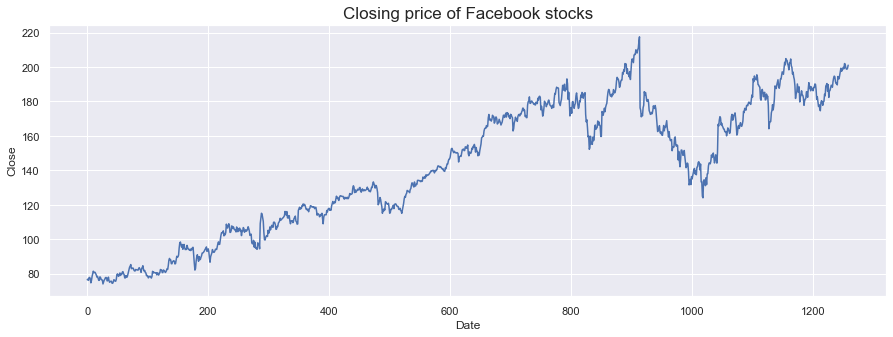

In [5]:
df['Close'].plot(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Closing price of Facebook stocks', size=17)
plt.show()

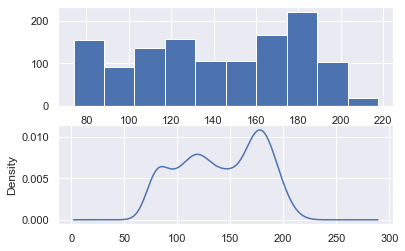

In [6]:
plt.subplot(211)
df['Close'].hist()

plt.subplot(212)
df['Close'].plot(kind='kde')
plt.show()

In [8]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MSE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

def augmented_dickey_fuller(series, column):
    print(f'Results of Dickey-Fuller test for column {column}')
    dftest = adfuller(series, autolag='AIC')
    dfout  = pd.Series(dftest[:4], index=['Test statistic', 'p-value', 'no lags used', 'number of observations'])

    for k, v in dftest[4].items():
        dfout['critical value (%s)'%k] = v
        print(dfout, end='\n\n')

        if dftest[1] <= 0.05:
            print('conclusion: ===>')
            print('Reject the null hypothesis')
            print('Data is stationary', end='\n\n')
        else:
            print('conclusion: ===>')
            print('Fail to reject the null hypothesis')
            print('Data is not stationary', end='\n\n')


augmented_dickey_fuller(df['Close'], 'Close')

Results of Dickey-Fuller test for column Close
Test statistic              -1.338096
p-value                      0.611568
no lags used                 0.000000
number of observations    1258.000000
critical value (1%)         -3.435559
dtype: float64

conclusion: ===>
Fail to reject the null hypothesis
Data is not stationary

Test statistic              -1.338096
p-value                      0.611568
no lags used                 0.000000
number of observations    1258.000000
critical value (1%)         -3.435559
critical value (5%)         -2.863840
dtype: float64

conclusion: ===>
Fail to reject the null hypothesis
Data is not stationary

Test statistic              -1.338096
p-value                      0.611568
no lags used                 0.000000
number of observations    1258.000000
critical value (1%)         -3.435559
critical value (5%)         -2.863840
critical value (10%)        -2.567995
dtype: float64

conclusion: ===>
Fail to reject the null hypothesis
Data is not stati

The pmdarima module will help us identify p, d, and q without the hassle of looking at the plot.

In [10]:
X = df[['Close']]
train, test = X[:-30], X[-30:]

stepwise_model = auto_arima(train, start_p=1, start_q=1, max_p=7, max_q=7, seasonal=False, d=None, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5926.792, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5929.302, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5930.825, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5930.810, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5928.648, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5928.521, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5930.139, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5932.491, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5932.541, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5927.184, Time=0.24 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.772 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1229
M

In [16]:
forecast, conf_int = stepwise_model.predict(n_periods=30, return_conf_int=True)
forecast = pd.DataFrame(forecast, columns=['close_pred'])
df_conf  = pd.DataFrame(conf_int, columns=['lower_bound', 'upper_bound'])
df_conf['new_index'] = range(1229, 1259)
df_conf = df_conf.set_index('new_index')
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 73.0120242822567
MSE is : 7.727928277453403
RMSE is : 8.54470738423831
MAPE is : 3.9182484906752095
R2 is : -2.9891195416802123



In [17]:
forecast['new_index'] = range(1229, 1259)
forecast.set_index('new_index', inplace=True)

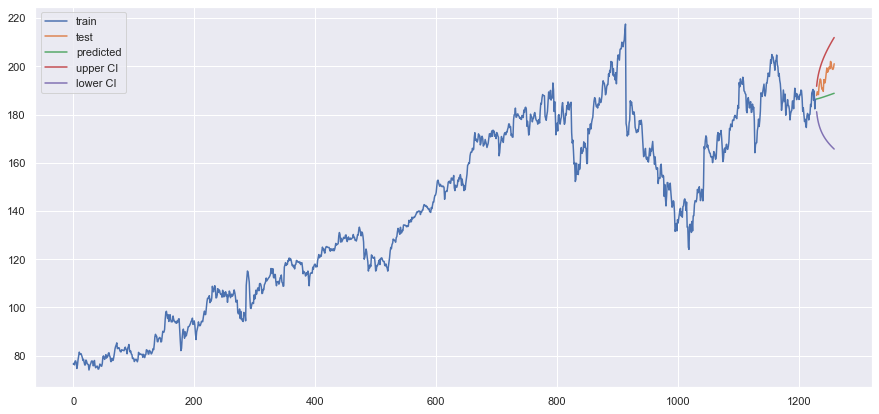

In [18]:
plt.figure(figsize=(15, 7))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(forecast, label='predicted')
plt.plot(df_conf.upper_bound, label='upper CI')
plt.plot(df_conf.lower_bound, label='lower CI')
plt.legend(loc='best')
plt.show()

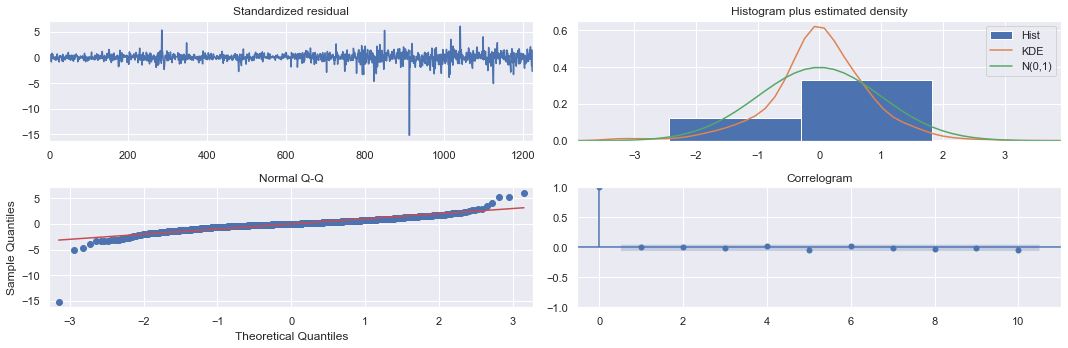

In [23]:
stepwise_model.plot_diagnostics()
plt.tight_layout()
plt.show()

### Arima summary
- works well with univariate data
- works only with stationary data (thus, real-world data is not going to have a good result)
- for non-stationary data with seasonality use seasonal-Arima or fractional-Arima
- for multivariate data use VARIMA

### SARIMA (seasonal arima)
$$ARIMA (p,d,q) * (P, D, Q)_m$$
